In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
import warnings
import seaborn as sns

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
class WeibullDemandGenerator:
   def __init__(self, num_samples, periods, k=2.0):
       self.num_samples = num_samples
       self.periods = periods
       self.k = k

   def estimate_weibull_scale(self, samples, M, n_tail_buckets=3, fixed_lambda=None):
       if fixed_lambda is not None:
           return fixed_lambda
           
       flat_samples = samples.flatten()
       tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples <= M)]
       n_at_threshold = np.sum(flat_samples == M)
       
       def neg_log_likelihood(scale):
           eps = 1e-10
           scale = max(scale, eps)
           
           uncensored = tail_samples[tail_samples < M]
           pdf_term = np.sum(np.log(eps + stats.weibull_min.pdf(
               uncensored - (M-n_tail_buckets), 
               c=self.k,
               scale=scale
           )))
           
           if n_at_threshold > 0:
               sf = stats.weibull_min.sf(n_tail_buckets - 1, c=self.k, scale=scale)
               threshold_term = n_at_threshold * np.log(eps + sf)
           else:
               threshold_term = 0
               
           return -(pdf_term + threshold_term)
       
       result = optimize.minimize_scalar(
           neg_log_likelihood, 
           bounds=(1e-6, 20), 
           method='bounded',
           options={'xatol': 1e-8}
       )

       if not result.success:
           warnings.warn(f"Scale estimation did not converge: {result.message}")
           
       return result.x

   def fit_and_sample(self, problem_params, demand_params, seed=None, fixed_lambda=None):
       if seed is not None:
           np.random.seed(seed)
       
       M = problem_params.get('censoring_threshold', 7)
       n_tail_buckets = problem_params.get('n_tail_buckets', 3)
       
       orig_samples = np.random.poisson(
           demand_params['mean'], 
           size=(self.num_samples, problem_params['n_stores'], self.periods)
       )
       
       imputed_samples = np.minimum(orig_samples, M)
       censored_mask = orig_samples >= M
       
       weibull_scale = self.estimate_weibull_scale(orig_samples, M, n_tail_buckets, fixed_lambda)
       
       n_censored = np.sum(censored_mask)
       lower_bound = stats.weibull_min.cdf(n_tail_buckets, c=self.k, scale=weibull_scale)
       uniform_samples = np.random.uniform(lower_bound, 1-1e-10, size=n_censored)
       
       censored_tails = np.floor(
           M + stats.weibull_min.ppf(uniform_samples, c=self.k, scale=weibull_scale) - n_tail_buckets
       ).astype(int)
       
       imputed_samples[censored_mask] = censored_tails
       
       return imputed_samples

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


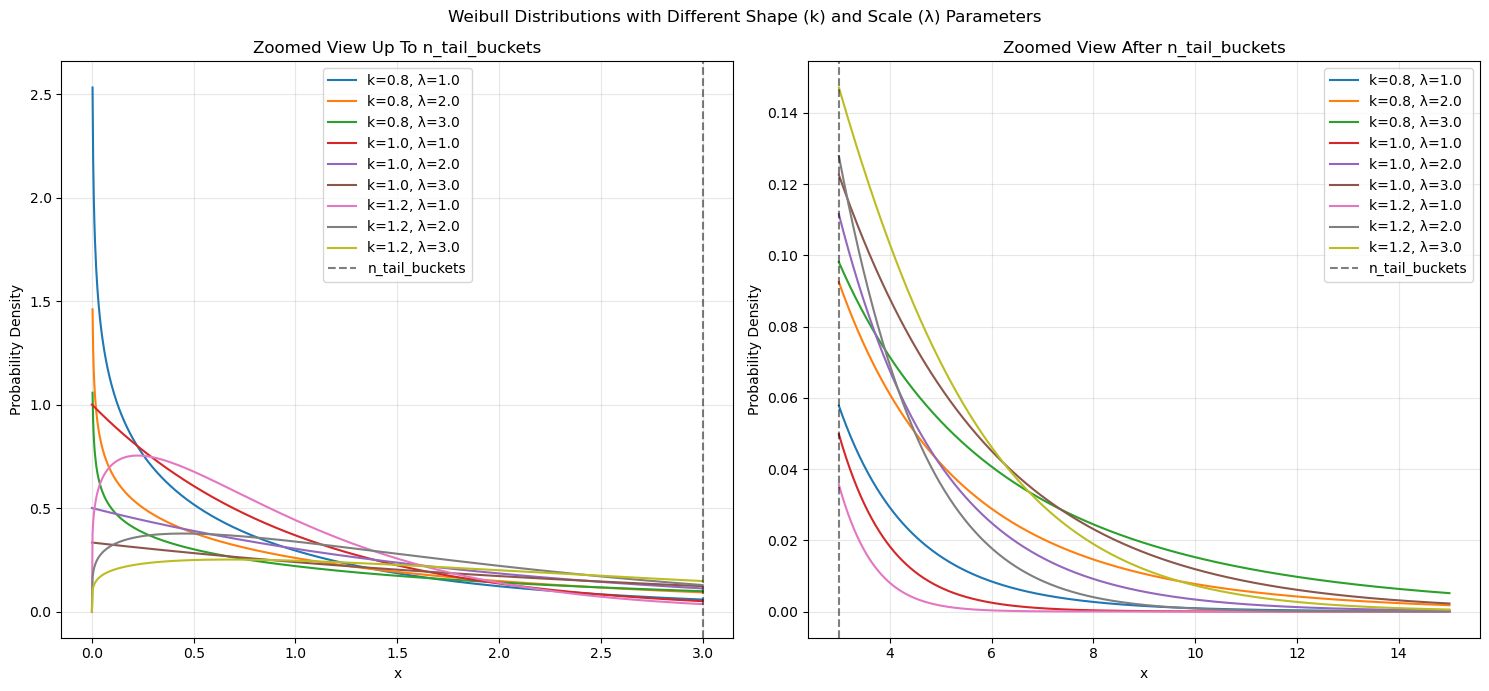

In [4]:
# %% cell 3 code

# Set up parameters for Weibull distributions
k_values = [0.8, 1.0, 1.2]
lambda_values = [1.0, 2.0, 3.0]
n_tail_buckets = 3

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Zoomed in plot up to n_tail_buckets
x1 = np.linspace(0, n_tail_buckets, 1000)
for k in k_values:
    for lambda_val in lambda_values:
        # Calculate Weibull PDF
        weibull_pdf = stats.weibull_min.pdf(x1, c=k, scale=lambda_val)
        ax1.plot(x1, weibull_pdf, label=f'k={k}, λ={lambda_val}')

ax1.axvline(x=n_tail_buckets, color='black', linestyle='--', alpha=0.5, label='n_tail_buckets')
ax1.set_title('Zoomed View Up To n_tail_buckets')
ax1.set_xlabel('x')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoomed plot after n_tail_buckets
x2 = np.linspace(n_tail_buckets, 15, 1000)
for k in k_values:
    for lambda_val in lambda_values:
        # Calculate Weibull PDF
        weibull_pdf = stats.weibull_min.pdf(x2, c=k, scale=lambda_val)
        ax2.plot(x2, weibull_pdf, label=f'k={k}, λ={lambda_val}')

ax2.axvline(x=n_tail_buckets, color='black', linestyle='--', alpha=0.5, label='n_tail_buckets')
ax2.set_title('Zoomed View After n_tail_buckets')
ax2.set_xlabel('x')
ax2.set_ylabel('Probability Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Weibull Distributions with Different Shape (k) and Scale (λ) Parameters')
plt.tight_layout()


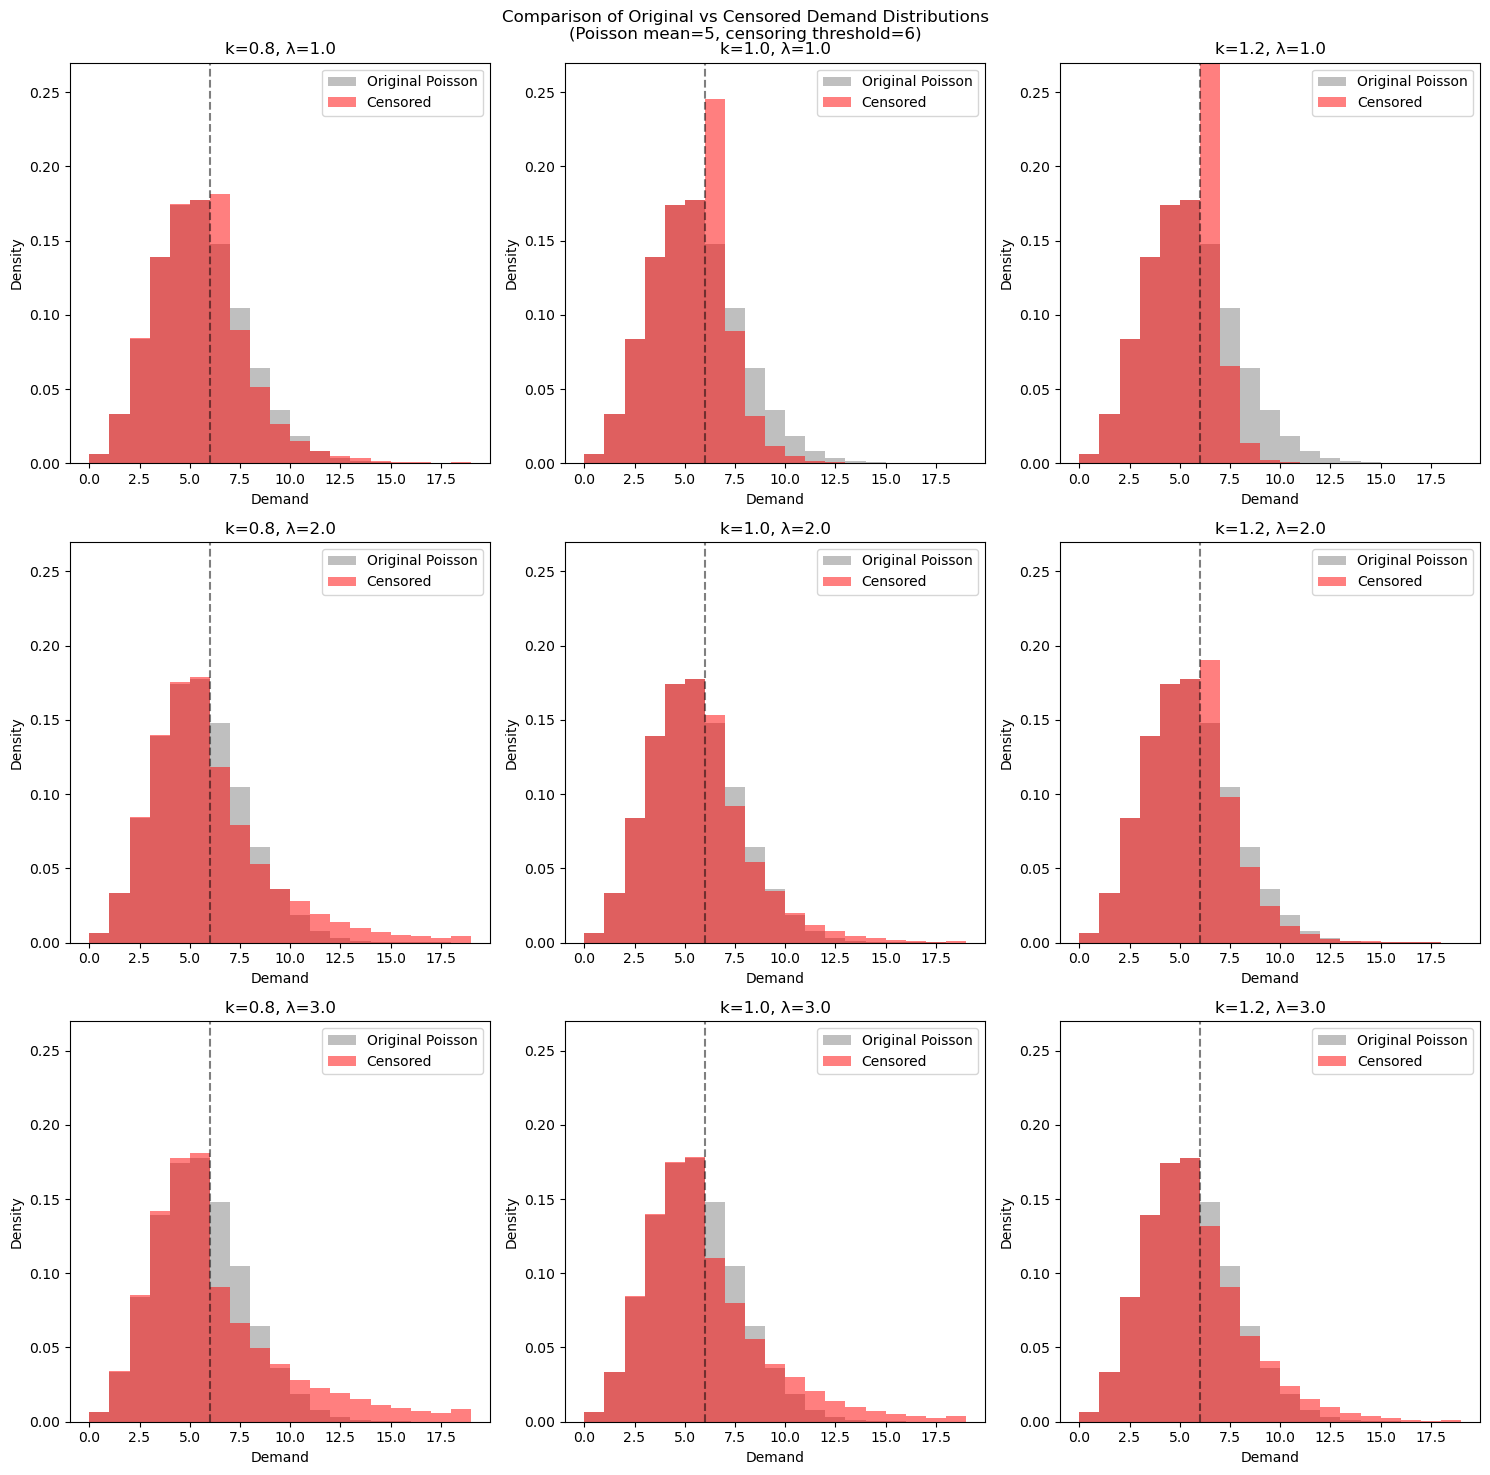

In [10]:
# Set up parameters
num_samples = 1000
periods = 50
censoring_threshold = 6
mean = 5
k_values = [0.8, 1.0, 1.2]
lambda_values = [1.0, 2.0, 3.0]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Comparison of Original vs Censored Demand Distributions\n' + 
             f'(Poisson mean={mean}, censoring threshold={censoring_threshold})')

np.random.seed(42)
poisson_samples = np.random.poisson(mean, size=num_samples*periods)

# First pass to find global y limits
y_max = 0
for i, fixed_lambda in enumerate(lambda_values):
    for j, k in enumerate(k_values):
        generator = WeibullDemandGenerator(num_samples=num_samples, periods=periods)
        generator.k = k
        
        problem_params = {
            'censoring_threshold': censoring_threshold,
            'n_stores': 1,
            'n_tail_buckets': 0
        }
        demand_params = {
            'mean': mean
        }
        
        censored_data = generator.fit_and_sample(problem_params, demand_params, seed=42, fixed_lambda=fixed_lambda)
        
        # Get max height from both histograms
        _, bins = np.histogram(poisson_samples, bins=range(0,20), density=True)
        hist1, _ = np.histogram(poisson_samples, bins=bins, density=True)
        hist2, _ = np.histogram(censored_data.flatten(), bins=bins, density=True)
        y_max = max(y_max, max(np.max(hist1), np.max(hist2)))

# Second pass to plot with consistent y limits        
for i, fixed_lambda in enumerate(lambda_values):
    for j, k in enumerate(k_values):
        generator = WeibullDemandGenerator(num_samples=num_samples, periods=periods)
        generator.k = k
        
        problem_params = {
            'censoring_threshold': censoring_threshold,
            'n_stores': 1,
            'n_tail_buckets': 3
        }
        demand_params = {
            'mean': mean
        }
        
        censored_data = generator.fit_and_sample(problem_params, demand_params, seed=42, fixed_lambda=fixed_lambda)
        
        ax = axes[i,j]
        
        ax.hist(poisson_samples, bins=range(0,20), alpha=0.5, density=True, label='Original Poisson', color='gray')
        ax.hist(censored_data.flatten(), bins=range(0,20), alpha=0.5, density=True, label='Censored', color='red')
        
        ax.axvline(x=censoring_threshold, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'k={k}, λ={fixed_lambda}')
        ax.set_xlabel('Demand')
        ax.set_ylabel('Density')
        ax.set_ylim(0, y_max * 1.1)  # Add 10% padding
        ax.legend()

plt.tight_layout()
plt.show()

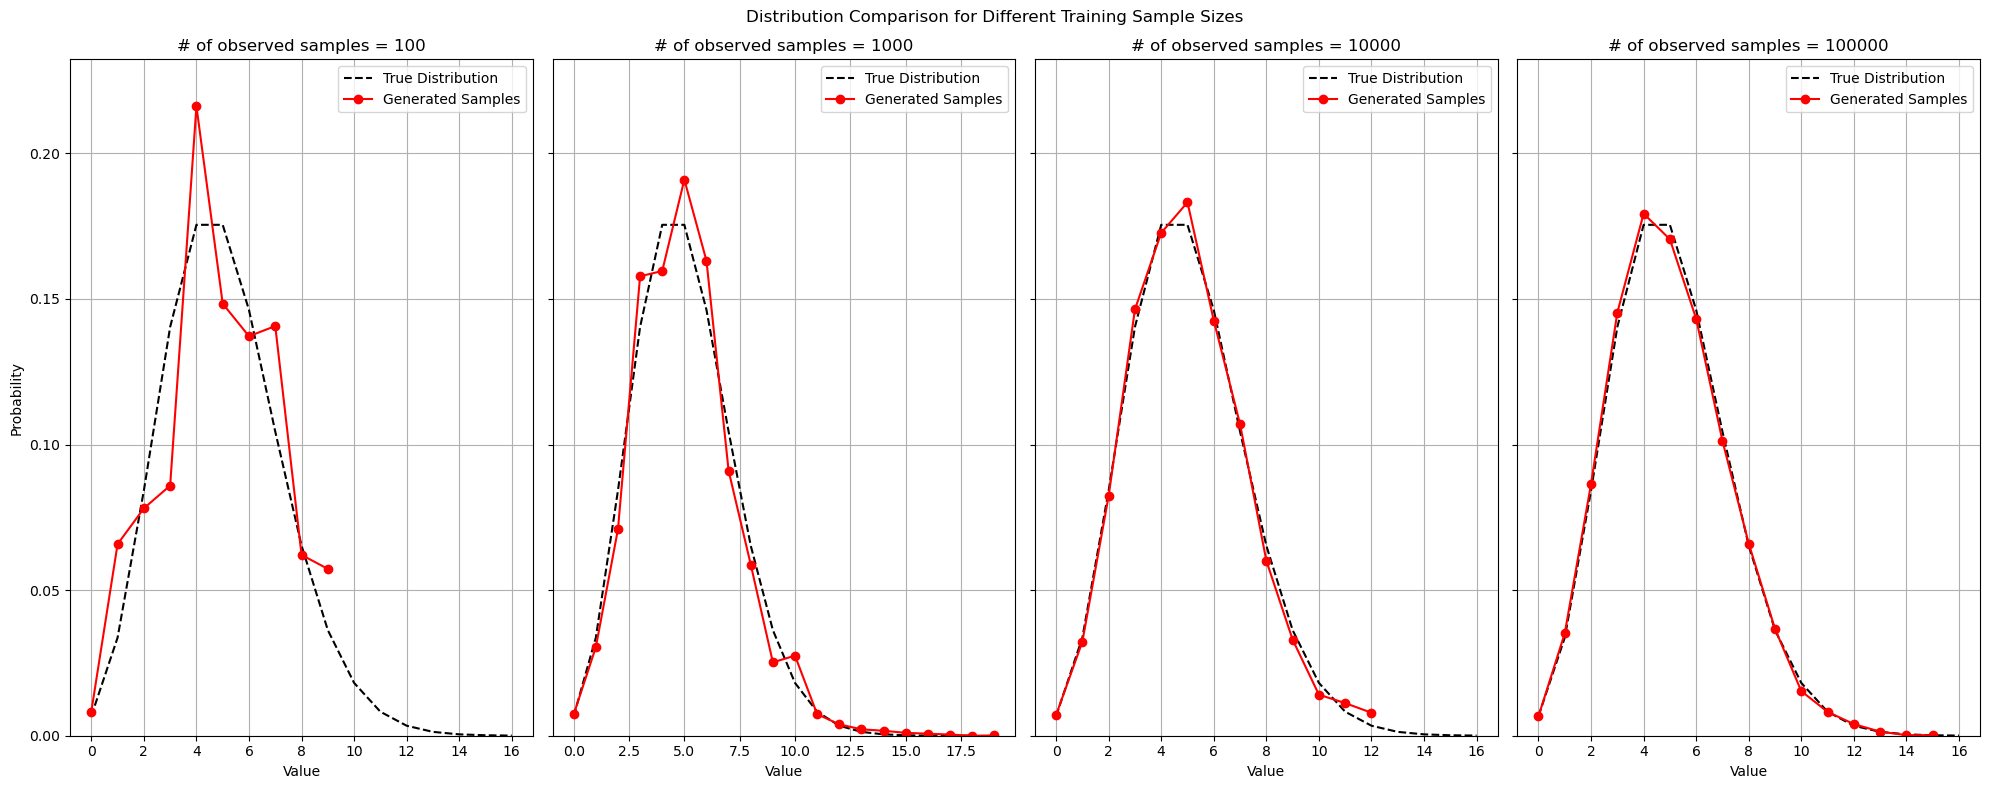

In [21]:
import numpy as np
from scipy import stats, optimize
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

class KMSampler:
    def __init__(self, num_samples, periods):
        self.kmf = None
        self.tail_rate = None
        self.max_uncensored = None
        self.num_samples = num_samples
        self.periods = periods
    
    def fit(self, observed_data, censoring_indicators, M, n_buckets=3):
        """Fit KM estimator and tail rate to data"""
        self.kmf = KaplanMeierFitter()
        self.kmf.fit(observed_data, censoring_indicators)
        
        # Get CDF values
        times = self.kmf.survival_function_.index
        cdf = 1 - self.kmf.survival_function_.values.flatten()
        
        # Get the last n_buckets points and their densities
        last_cdfs = cdf[-(n_buckets+1):]  # Get last 3 CDF values
        densities = np.diff(last_cdfs)     # Get P(X = k) for k in [M-2, M-1, M]
        p_greater_M = 1 - last_cdfs[-1]    # P(X > M)
        densities = np.append(densities, p_greater_M)
        
        def neg_log_likelihood(rate):
            if rate <= 0:
                return np.inf
            
            # Calculate model probabilities
            model_probs = np.array([
                np.exp(-rate * i) - np.exp(-rate * (i + 1))
                for i in range(n_buckets)
            ])
            # for last bucket, model prob is np.exp(-rate * n_buckets). need to add it to the last bucket
            model_probs = np.append(model_probs, np.exp(-rate * n_buckets))
            
            # Avoid log(0)
            valid_idx = (densities > 0) & (model_probs > 0)
            if not np.any(valid_idx):
                return np.inf
                
            return -np.sum(densities[valid_idx] * np.log(model_probs[valid_idx]))
        
        result = optimize.minimize_scalar(
            neg_log_likelihood, 
            bounds=(0.001, 2.0),
            method='bounded'
        )
        
        self.tail_rate = result.x
        self.threshold = times[-1]  # This is M
        
    def sample(self, n_samples):
        """Generate new samples from fitted distribution"""
        if self.kmf is None:
            raise ValueError("Must fit model before sampling")
            
        # Get survival function values
        times = np.arange(np.min(self.kmf.survival_function_.index), 
                        np.max(self.kmf.survival_function_.index) + 1)
        cdf = 1 - self.kmf.survival_function_at_times(times).values
        
        samples = np.zeros(n_samples)
        for i in range(n_samples):
            u = np.random.uniform(0, 1)
            
            # Find the smallest time where CDF is greater than u
            mask = cdf >= u
            if np.any(mask):  # Use KM distribution
                samples[i] = times[np.where(mask)[0][0]]
            else:
                # Sample from tail using threshold (M) instead of max_uncensored
                excess = np.random.exponential(1/self.tail_rate)
                samples[i] = self.threshold + np.floor(excess)

        return samples.astype(int)

    def fit_and_sample(self, n_fit, problem_params, demand_params, censoring_process, seed=None):
        """
        Run experiment fitting KM to n_fit samples and generating n_generate new ones
        """
        if seed is not None:
            np.random.seed(seed)
            
        # Generate training data
        true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
        thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)
        
        # Apply censoring
        observed = np.minimum(true_demand, thresholds)
        censoring_indicators = (true_demand <= thresholds).astype(int)

        # Fit sampler
        self.fit(observed, censoring_indicators, M=np.max(thresholds))
        
        n_generate = problem_params['n_stores'] * self.periods * self.num_samples

        # Generate new samples
        generated_samples = self.sample(n_generate)

        # reshape to self.num_samples, self.n_stores, self.periods
        generated_samples = generated_samples.reshape(self.num_samples, problem_params['n_stores'], self.periods)

        return generated_samples

# Set up parameters
demand_params = {'mean': 5}
censoring_process = {'mean': 6}
n_generate = 10000

# Create figure with 4 subplots in a row
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Distribution Comparison for Different Training Sample Sizes')

# Test different n_fit values
n_fit_values = [10**2, 10**3, 10**4, 10**5]

# First pass to get max y value
y_max = 0
for n_fit in n_fit_values:
    sampler = KMSampler(num_samples=1000, periods=1)
    true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
    thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)
    
    observed = np.minimum(true_demand, thresholds)
    censoring_indicators = (true_demand <= thresholds).astype(int)
    
    sampler.fit(observed, censoring_indicators, M=np.max(thresholds))
    generated_samples = sampler.sample(n_generate)
    
    x = np.arange(0, max(20, np.max(generated_samples)))
    y_max = max(y_max, np.max(stats.poisson.pmf(x, demand_params['mean'])))
    
    all_values = np.arange(min(generated_samples), max(generated_samples) + 1)
    counts = np.bincount(generated_samples.astype(int), 
                        minlength=max(generated_samples) + 1)[min(generated_samples):]
    y_max = max(y_max, np.max(counts/len(generated_samples)))

# Second pass to plot with consistent y limits
for i, n_fit in enumerate(n_fit_values):
    # Generate samples
    sampler = KMSampler(num_samples=1000, periods=1)
    true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
    thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)
    
    # Apply censoring
    observed = np.minimum(true_demand, thresholds)
    censoring_indicators = (true_demand <= thresholds).astype(int)
    
    # Fit and generate
    sampler.fit(observed, censoring_indicators, M=np.max(thresholds))
    generated_samples = sampler.sample(n_generate)
    
    # Plot
    ax = axes[i]
    
    # True distribution
    x = np.arange(0, max(17, np.max(generated_samples)))
    ax.plot(x, stats.poisson.pmf(x, demand_params['mean']), 
            'k--', label='True Distribution')
    
    # Generated samples
    all_values = np.arange(min(generated_samples), max(generated_samples) + 1)
    counts = np.bincount(generated_samples.astype(int), 
                        minlength=max(generated_samples) + 1)[min(generated_samples):]
    ax.plot(all_values, counts/len(generated_samples), 
            'ro-', label='Generated Samples')
    
    ax.set_title(f'# of observed samples = {n_fit}')
    ax.set_xlabel('Value')
    ax.set_ylim(0, y_max)  # Add 10% padding
    if i == 0:  # Only show y-label for leftmost plot
        ax.set_ylabel('Probability')
    else:
        ax.set_yticklabels([])  # Hide y-tick labels for other plots
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Generate samples
n_fit = 10**5
true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)

# Apply censoring
observed = np.minimum(true_demand, thresholds)
censoring_indicators = (true_demand <= thresholds).astype(int)

# Count failures at each demand value
max_demand = int(np.max(observed))
for demand in range(max_demand + 1):
    failures = np.sum((observed == demand) & (censoring_indicators == 1))
    print(f"Number of failures at demand {demand}: {failures}")

Number of failures at demand 0: 650
Number of failures at demand 1: 3439
Number of failures at demand 2: 8065
Number of failures at demand 3: 13079
Number of failures at demand 4: 14851
Number of failures at demand 5: 12674
Number of failures at demand 6: 8189
Number of failures at demand 7: 4101
Number of failures at demand 8: 1720
Number of failures at demand 9: 550
Number of failures at demand 10: 154
Number of failures at demand 11: 36
Number of failures at demand 12: 7
Number of failures at demand 13: 0
Number of failures at demand 14: 0


In [4]:
km_sampler = KMSampler(num_samples=1000, periods=50)

problem_params = {'n_stores': 5}
demand_params = {'mean': 5}
censoring_process = {'mean': 6}
n_fit = 10000 # samples to fit the KM (equals to samples*periods*n_stores of the fictituous setting were data was gathered)

samples = km_sampler.fit_and_sample(n_fit, problem_params, demand_params, censoring_process, seed=42)